Наш дорогой Георгий разметил 10 партий, поэтому теперь мы можем поиграться с классическими моделями для определения интересности ходов. Начнём с так называемой "базы"

Хотя перед этим, пару слов, почему мы будем оптимизировать `precision`, а не какую-либо другую метрику.

В нашем случае `accuracy` не даст ровным счётом ничего: **положительный класс гораздо реже встречается, чем отрицательный.**

Высокий `recall` будет означать, что иногда наша модель будет неинтересные моменты помечать интересными, а это **потеря внимания зрителя, минус просмотры, минус деньги, короче плохо**.

А вот высокий `precision` звучит отлично: **если модель пометила момент как интересный, то он действительно интересный**. Да, некоторые интересные моменты мы пропустим, но кого это волнует, когда у нас под рукой 6 миллиардов партий в открытой базе LiChess? К тому же мы пока что экспериментируем, и эта модель будет неплохой отправной точкой

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

In [2]:
data = pd.read_csv('train.csv')
data

,delta_score,deviation_from_pv,threats_to_opponent,threats_from_opponent,legal_moves_diff,sacrifice,advantage_change,mate_distance,king_under_attack,is_capture,is_check,is_checkmate,cnt_promotion,is_used_promotion,is_castling,target
0,12.000000,0,0,0,0,0,0,0.0,0,False,False,False,0,False,False,0
1,2.000000,1,0,0,0,0,0,0.0,0,False,False,False,0,False,False,0
2,8.333333,0,0,0,0,0,0,0.0,0,False,False,False,0,False,False,0
3,17.333333,0,1,1,1,0,0,0.0,0,False,False,False,0,False,False,0
4,50.666667,0,1,1,0,0,0,0.0,0,True,False,False,0,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,17.666667,0,1,1,-13,0,0,0.0,1,False,True,False,0,False,False,0
775,-10.000000,0,1,0,0,0,0,0.0,0,False,False,False,0,False,False,0
776,14.666667,0,2,1,-12,0,0,0.0,1,False,True,False,0,False,False,0
777,4.000000,0,1,1,0,0,0,0.0,0,False,False,False,0,False,False,0


In [3]:
X = data.drop('target', axis=1)
y = data['target']

# scl = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# X_train = scl.fit_transform(X_train)
# X_test = scl.transform(X_test)

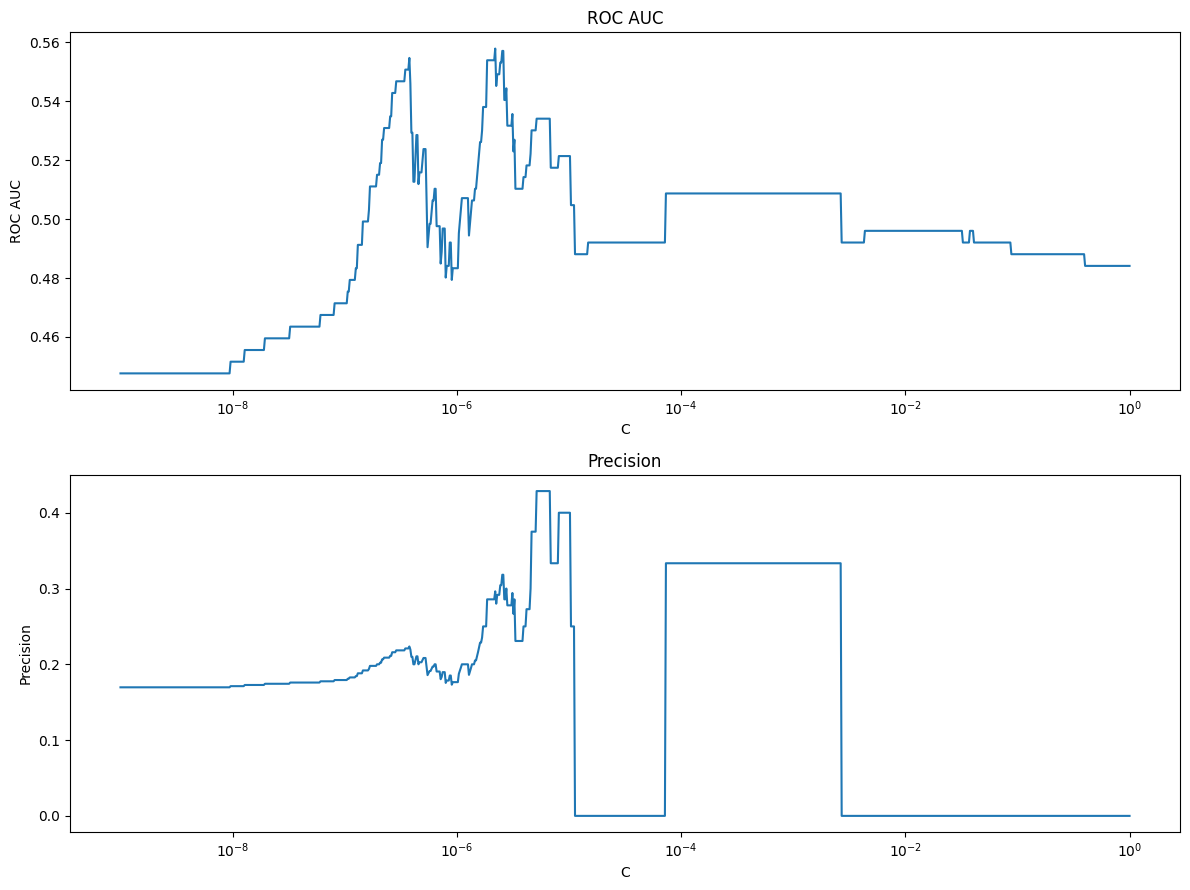

Best C (by precision): 5.148867450137487e-06
Best C (by auc-roc): 2.1995930680300747e-06


In [4]:
import matplotlib.pyplot as plt

Cs = np.logspace(start=-9, stop=0, num=1000)
rocs = []
prs = []

for C in Cs:
    model = LinearSVC(C=C)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    pr = precision_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    rocs.append(auc_roc)
    prs.append(pr)

rocs = np.array(rocs)
prs = np.array(prs)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))

ax[0].plot(Cs, rocs)
ax[0].set_title('ROC AUC')
ax[0].set_xlabel('C')
ax[0].set_ylabel('ROC AUC')
ax[0].set_xscale('log')  # Логарифмическая шкала на оси x

ax[1].plot(Cs, prs)
ax[1].set_title('Precision')
ax[1].set_xlabel('C')
ax[1].set_ylabel('Precision')
ax[1].set_xscale('log')  # Логарифмическая шкала на оси x

plt.tight_layout()
plt.show()

print(f'Best C (by precision): {Cs[np.argmax(prs)]}')
print(f'Best C (by auc-roc): {Cs[np.argmax(rocs)]}')

Точность около 35% и auc-roc близко к 50%... Такая себе модель, конечно. Дело в том, что мы не учитываем специфику данных. Линейная модель пытается предсказать является ли ход интересным. Но разметка данных показывает скорее "входит ли ход в интересный момент".

Прежде чем перейти к другим идеям, давайте применим тяжёлую артиллерию: случайный лес

In [5]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict((X_test))
pr = precision_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
print(f'Precision: {pr}')
print(f'AUC-ROC: {auc_roc}')

Precision: 0.36363636363636365
AUC-ROC: 0.5388888888888889


Результат почти такой же. В общем, нужно думать, как учитывать последовательный характер данных.

Хочется накапливать информацию от предыдущих ходов и по накопленной информации определять, является ли текущий ход интересным, а точнее, входит ли текущий ход в промежуток интересного момента.

Очевидно, речь идёт про рекуррентную нейронную сеть.

Но для начала нужно разбить датасет на игры, потому что наша сетка не должна "помнить" ходы из предыдущих партий:

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [7]:
moves_sequences = []
labels = []

for i in range(1, 11):
    train_part = pd.read_csv(f'marked_up/tmp/{i}.csv')
    X_part, y_part = train_part.drop('target', axis=1), train_part['target']

    moves_sequences.append(torch.tensor(X_part.astype(float).to_numpy(), dtype=torch.float32))
    labels.append(torch.tensor(y_part.to_numpy(), dtype=torch.float32))

train_moves, test_moves = moves_sequences[:-2], moves_sequences[-2:]
train_labels, test_labels = labels[:-2], labels[-2:]

Очевидно, что по меркам нейросетей это ничтожное количество данных. Но давайте по крайне мере попробуем

In [8]:
# Определяем класс Dataset
class MovesDataset(Dataset):
    def __init__(self, sequences, labels):
        """
        :param sequences: список тензоров размером [seq_len, num_features]
        :param labels: список тензоров с метками, можно оставить в виде одномерного массива для каждого примера
        """
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = MovesDataset(train_moves, train_labels)
test_dataset = MovesDataset(test_moves, test_labels)

In [9]:
# Создаем функцию для формирования батчей.
# Если длины последовательностей различаются, используем pad_sequence для паддинга.
def collate_fn(batch):
    # batch – список кортежей (sequence, label)
    sequences, labels = zip(*batch)
    
    # Если у нас метки в виде векторов (например, последовательность меток для каждого шага)
    # и они имеют одинаковую длину, можно оставить как есть.
    # Если это одиночные метки для последовательности, можно конвертировать их в тензор.
    # Здесь предполагаем, что каждая последовательность может иметь разную длину.
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    
    # Паддинг для меток: [batch, max_seq_len]
    # Задаем, например, значение -1 для паддинга (оно не должно встречаться в реальных метках)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-1)
    
    return sequences_padded, labels_padded

Теперь сконструируем модель:

In [10]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sigmoid = nn.Sigmoid()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0)) # out - [batch_size, seq_len, hidden_size]
        decision = self.fc(out)
        probas = self.sigmoid(decision)
        return probas.squeeze()
        # out = self.fc(out[:, -1, :])

In [11]:
# Параметры модели
input_size = 15  # Размерность векторов в последовательности
hidden_size = 30  # Размерность скрытого состояния LSTM
num_layers = 3  # Количество слоев LSTM
num_classes = 1  # Количество классов (для бинарной классификации надо установить значение 1)
num_epochs = 1000  # Количество эпох обучения

In [12]:
model = LSTMClassifier(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_classes=num_classes
)

adam = optim.Adam(model.parameters(), lr=0.001)
clr = lr_scheduler.CyclicLR(adam, base_lr=1e-6, max_lr=1e-3, step_size_up=100)

criterion = nn.CrossEntropyLoss(ignore_index=-1)

test_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

def validate(a):
    prs = []
    with torch.no_grad():
        for seq, lab in test_dataloader:
            y_pred = a(seq).detach().numpy().reshape((-1, 1)) > 0.5
            y_true = lab.detach().numpy().reshape((-1, 1))
            prs.append(precision_score(y_true, y_pred, zero_division=0)) 
    return sum(prs) / len(prs)

# Создаем DataLoader
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

for i in range(num_epochs):
    for batch_idx, (batch_sequences, batch_labels) in enumerate(train_dataloader):
        # print(batch_sequences.shape, batch_labels.shape)
        model.train()

        outputs = model(batch_sequences)
        # print(f'output shape: {outputs.shape}')
        loss = criterion(outputs, batch_labels)

        adam.zero_grad()
        loss.backward()
        adam.step()
    
    cur_score = validate(model)

    clr.step()
    print(cur_score, clr.get_last_lr())


0.2077248275096411 [1.0989999999999788e-05]
0.2077248275096411 [2.098000000000002e-05]
0.2077248275096411 [3.096999999999981e-05]
0.2077248275096411 [4.0960000000000035e-05]
0.2077248275096411 [5.094999999999982e-05]
0.2077248275096411 [6.094000000000006e-05]
0.2077248275096411 [7.092999999999985e-05]
0.2077248275096411 [8.092000000000007e-05]
0.2077248275096411 [9.090999999999986e-05]
0.2077248275096411 [0.0001009000000000001]
0.2077248275096411 [0.00011088999999999988]
0.2077248275096411 [0.00012088000000000012]
0.2077248275096411 [0.00013086999999999992]
0.2077248275096411 [0.00014086000000000014]
0.2077248275096411 [0.00015084999999999993]
0.2077248275096411 [0.00016084000000000015]
0.2077248275096411 [0.00017082999999999993]
0.2077248275096411 [0.00018082000000000018]
0.2077248275096411 [0.00019080999999999997]
0.20849713872245576 [0.0002008000000000002]
0.20849713872245576 [0.00021078999999999998]
0.21013007929622624 [0.00022078000000000023]
0.2107106803891224 [0.0002307700000000

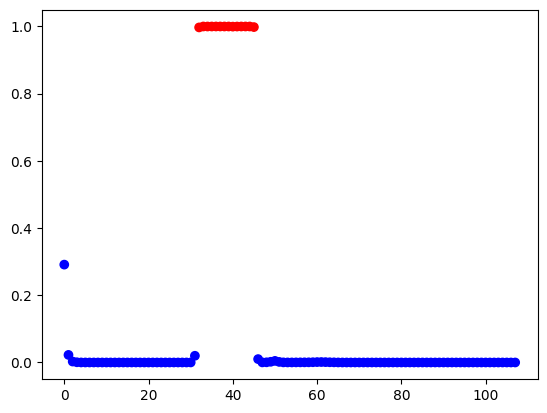

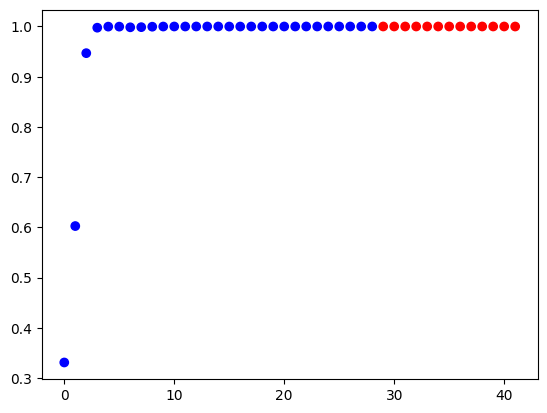

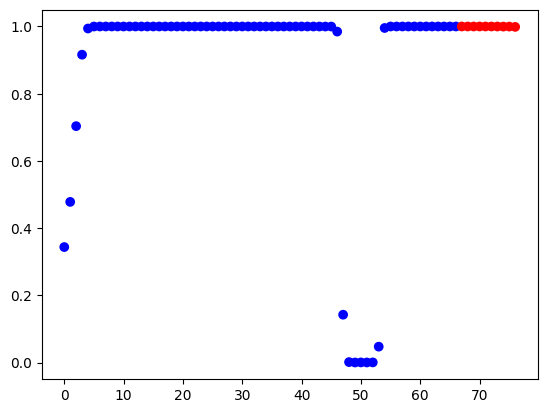

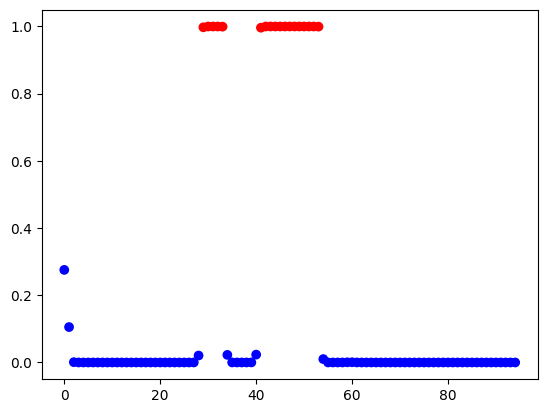

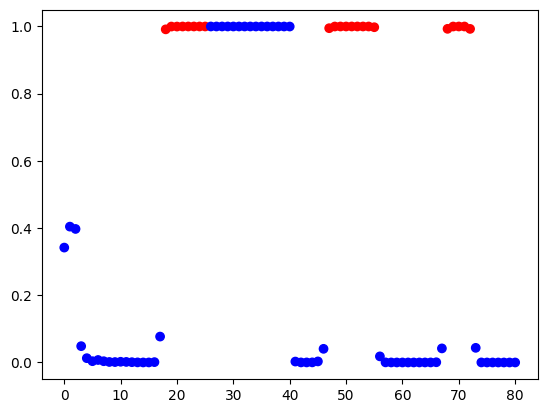

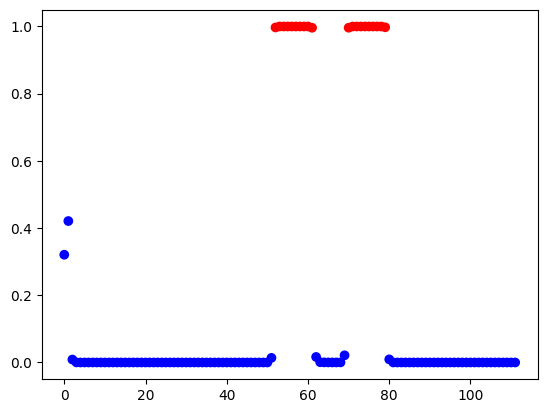

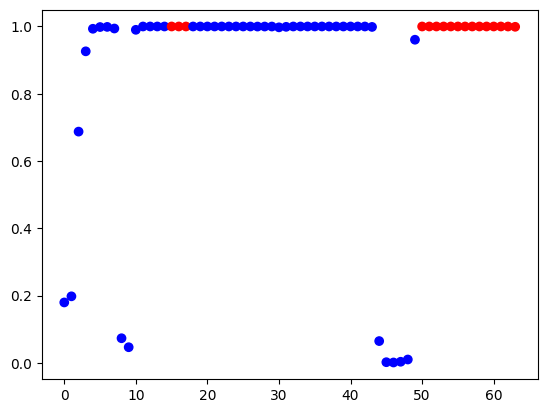

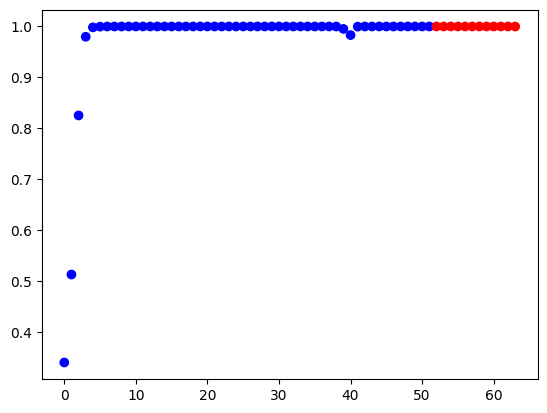

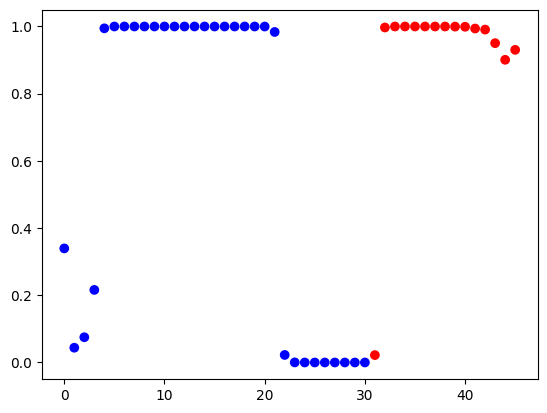

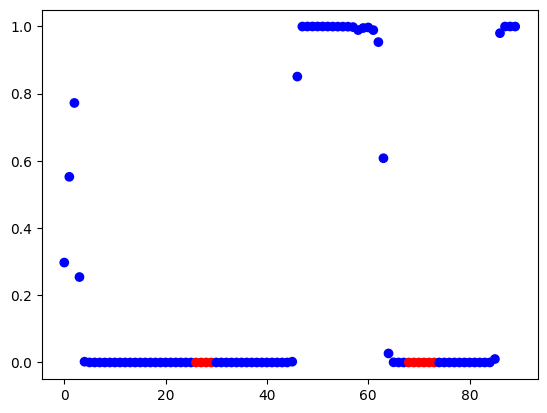

In [13]:
import matplotlib.pyplot as plt

batch_size = 1
dataset = MovesDataset(moves_sequences, labels)
dataloader = DataLoader(dataset)
for i, (batch_sequences, batch_labels) in enumerate(dataloader):
    y_pred = model(batch_sequences).detach().numpy().reshape((-1, 1))
    y_true = batch_labels.detach().numpy().reshape((-1, 1))
    plt.scatter(x=np.arange(y_pred.shape[0]), y=y_pred, c=y_true, cmap='bwr')
    plt.show()

Странно. Я думал, что модель переобучится и идеально подстроится под все данные. Но нет, во-первых она некоторые партии полностью пометила как интересные, а во-вторых, она даже что-то поняла и смогла на тестовых данных (последние два графика) один раз угадать с интересным моментом. Возможно, проблема в размеченных данных. Возможно, проблема в признаках

Тем не менее, пока что мы ничего не можем сделать с этими данными. Давайте идти дальше